In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'new-york-city-airbnb-open-data:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F268833%2F611395%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240701%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240701T232030Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D3201312e694b9d591e7af82a0a26fd14b9f1597d1ceacada4e92ce3ee48518518a5286fdf6a145c3bb87b703e936eb575f4be27ab8a992c3eb90aae5af25bd70251c3e0093c81149b25f0bde91c8736f3038cac04cf20b8c43d0340c4ef82b86be7ff756ff3afdf17d60c534fa3bdf25e940793eca7618844b8fe97a10b070ab4e0ee6ab3ddcfab13bb2dbf9eab22c202da8b43003e1d7582001f2938246c00821479980ccce71aba7ce985b98b0c07c02edc64eb69d3067c99dbaa0a0e4f2799b1c122735cd0b3f4d5e48af79eb4ec360f64455dd5e565411196a2db1d5ec46c6e1df7e39781b7bf8b4b6b7daa0c8eb18969905fad8409f72cb6644f5f5cb3f,nyc-boroughs:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5275715%2F8777673%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240701%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240701T232030Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Db2744da8bb646e69fffca25acd9d0e202d318e322b6218a99e0b75ce59d0e637eacde294fca464eb73534772c9fc0fdafe5ef4000c3351d95638a1f7e52f64220cebdbc087e78f404714d5d2a026b45afb7c0dda0bb1f9b5d1d6b73bbdbea275da92813e301815fb6b30f759e347ef1c4f4d8b51c2d4173af6ab178f438c521392965eb6ae84a943078f569149e2ce8c27fe618462264f57b525563da4df94ea0420b40bf9cc6e8cee424d9007cb3c6043f4159a3fa8e415128f211b13d99e69bc67ac3347022abd4d4923aeb21abc1acc3721dcadba4ca1e0aa3bca320640cb21b349a8ca8be30ed0bc9d246d3c9201900821c2b5ccc75d16c5c50ebcbfef70'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2562692 bytes downloaded
Downloaded and uncompressed: new-york-city-airbnb-open-data
[==================================================] 926324 bytes downloaded
Downloaded and uncompressed: nyc-boroughs
Data source import complete.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn.model_selection import train_test_split

df = pd.read_csv('/kaggle/input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')

df.dtypes

#replacing NaN's with mean and mode of corresponding columns

numerical_cols = df.select_dtypes(include=['int64','float64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

# Replace NaN values in numerical columns with the mean
for col in numerical_cols:
    df[col].fillna(df[col].mean(), inplace=True)

# Replace NaN values in categorical columns with the mode
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)


In [4]:
# Removing unnecessary columns

columns_to_keep = ["neighbourhood_group", "neighbourhood", "room_type", "price", "minimum_nights", "number_of_reviews", "reviews_per_month", "availability_365"]

df_kept = df.filter(items=columns_to_keep)


In [5]:
#shuffling and splitting the dataset

df_shuffled = df_kept.sample(frac=1,random_state=42).reset_index(drop=True)

train , test = train_test_split(df_shuffled, test_size=0.1, random_state=42)

print("training shape ", train.shape)
print("testing shape ",test.shape)

train.head(5)

training shape  (44005, 8)
testing shape  (4890, 8)


,neighbourhood_group,neighbourhood,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
18853,Bronx,University Heights,Private room,43,3,36,1.26,365
5011,Manhattan,Upper West Side,Shared room,68,3,105,2.09,302
34244,Bronx,Longwood,Private room,100,3,2,0.22,207
25590,Manhattan,East Village,Entire home/apt,549,5,8,4.29,155
42735,Brooklyn,Crown Heights,Entire home/apt,185,3,56,1.25,333


# EDA

## checking for correlation between variables

In [6]:
num = train.select_dtypes(exclude="object")

num_corr=num.corr()

num.corr()


,price,minimum_nights,number_of_reviews,reviews_per_month,availability_365
price,1.000000,0.047605,-0.046750,-0.023184,0.080680
minimum_nights,0.047605,1.000000,-0.080072,-0.091452,0.141356
number_of_reviews,-0.046750,-0.080072,1.000000,0.530612,0.174667
reviews_per_month,-0.023184,-0.091452,0.530612,1.000000,0.165432
availability_365,0.080680,0.141356,0.174667,0.165432,1.000000


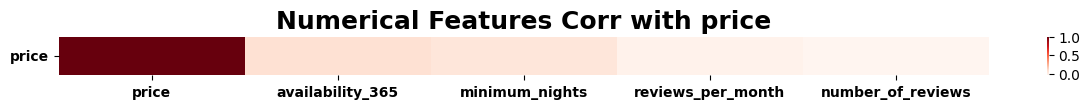

In [7]:
# plotting correlation plot

fig , ax = plt.subplots(figsize = (15,0.5))

sns.heatmap(num_corr.sort_values(by=['price'], ascending=False)[['price']].T, cmap='Reds')
plt.title('Numerical Features Corr with price', weight='bold', fontsize=18)
plt.xticks(weight='bold')
plt.yticks(weight='bold', color='black', rotation=0)
plt.show()

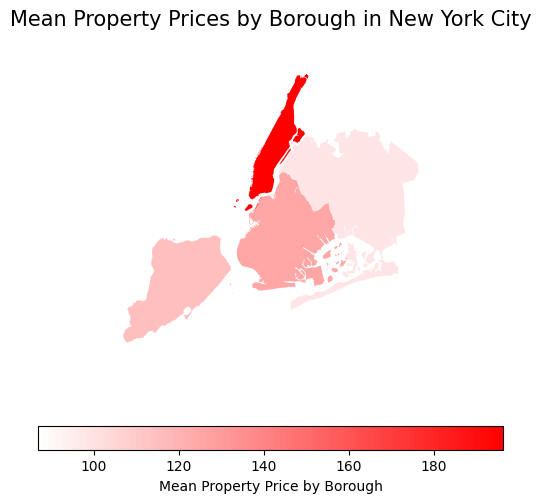

In [8]:
import matplotlib.pyplot as plt
import geopandas as gpd
from matplotlib.colors import LinearSegmentedColormap

# calculating mean price of each borough
mean_prices = train.groupby('neighbourhood_group')['price'].mean().reset_index()
mean_prices.columns = ['neighbourhood_group', 'mean_price']

# Changing name of neighbourhood_group to boro_name ti be able to merge
mean_prices = mean_prices.rename(columns={'neighbourhood_group':'boro_name'})

# reading shapefile and plotting it
nyc_boroughs = gpd.read_file('/kaggle/input/nyc-boroughs/geo_export_c25e77b1-b883-415d-8b6a-d1c0050a1a4b.shp')

# merging geodataframe with mean price
nyc_boroughs = nyc_boroughs.merge(mean_prices, on="boro_name")

# Define a custom colormap: white to red
colors = ['white', 'red']
n_bins = 100  # Number of color bins
cmap = LinearSegmentedColormap.from_list('white_to_red', colors, N=n_bins)

# plotting the figure
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
nyc_boroughs.plot(column='mean_price', cmap=cmap , ax=ax, legend=True,
                  legend_kwds={'label': "Mean Property Price by Borough",
                               'orientation': "horizontal"})
ax.set_title('Mean Property Prices by Borough in New York City', fontsize=15)
ax.set_axis_off()
plt.show()


### Let's graph a plot showing different price and property types(room_type) based on boroughs to see if there is a skewed or unbalanced distribution in our data.
### Spoiler Alert : We don't for both price and room_type!

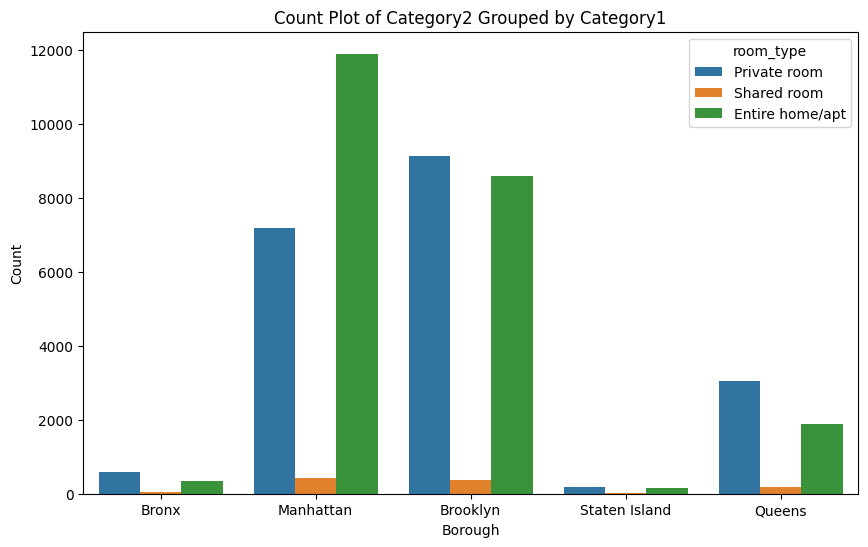

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

# Draw a count plot using seaborn
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='neighbourhood_group', hue='room_type')

# Add title and labels
plt.title('Count Plot of Category2 Grouped by Category1')
plt.xlabel('Borough')
plt.ylabel('Count')

# Show the plot
plt.show()

We have unbalanced training set in all 5 boroughs

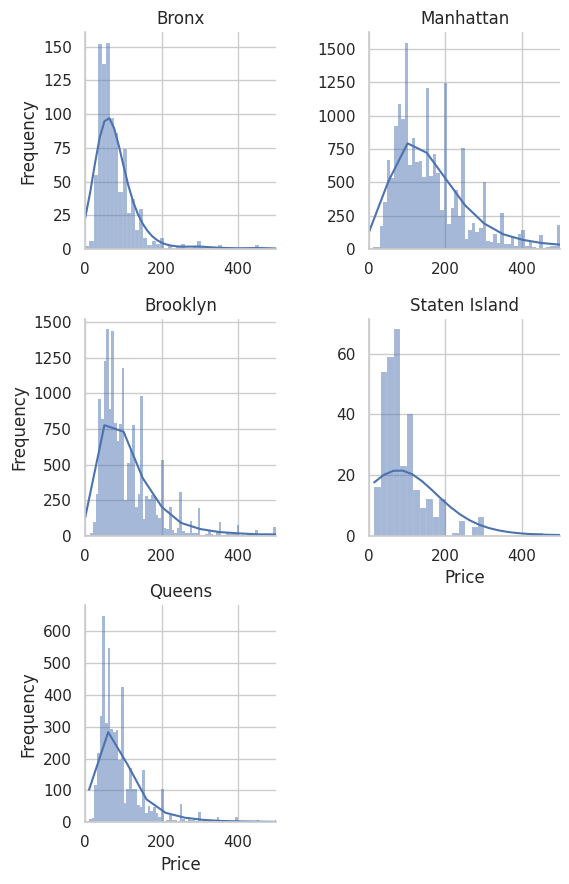

In [10]:
# Set the aesthetics for the plots
sns.set(style="whitegrid")

# Create a distribution plot for each group in the 'Category' column
g = sns.FacetGrid(train, col="neighbourhood_group", col_wrap=2, sharex=False, sharey=False)
g.map(sns.histplot, "price", kde=True)
for ax in g.axes.flatten():
    ax.set_xlim(0, 500)

# Add titles and labels
g.set_titles(col_template="{col_name}")
g.set_axis_labels("Price", "Frequency")

# Show the plot
plt.show()

Apparenly positively skewed. Catiously, let's say all numerical values are skewed.

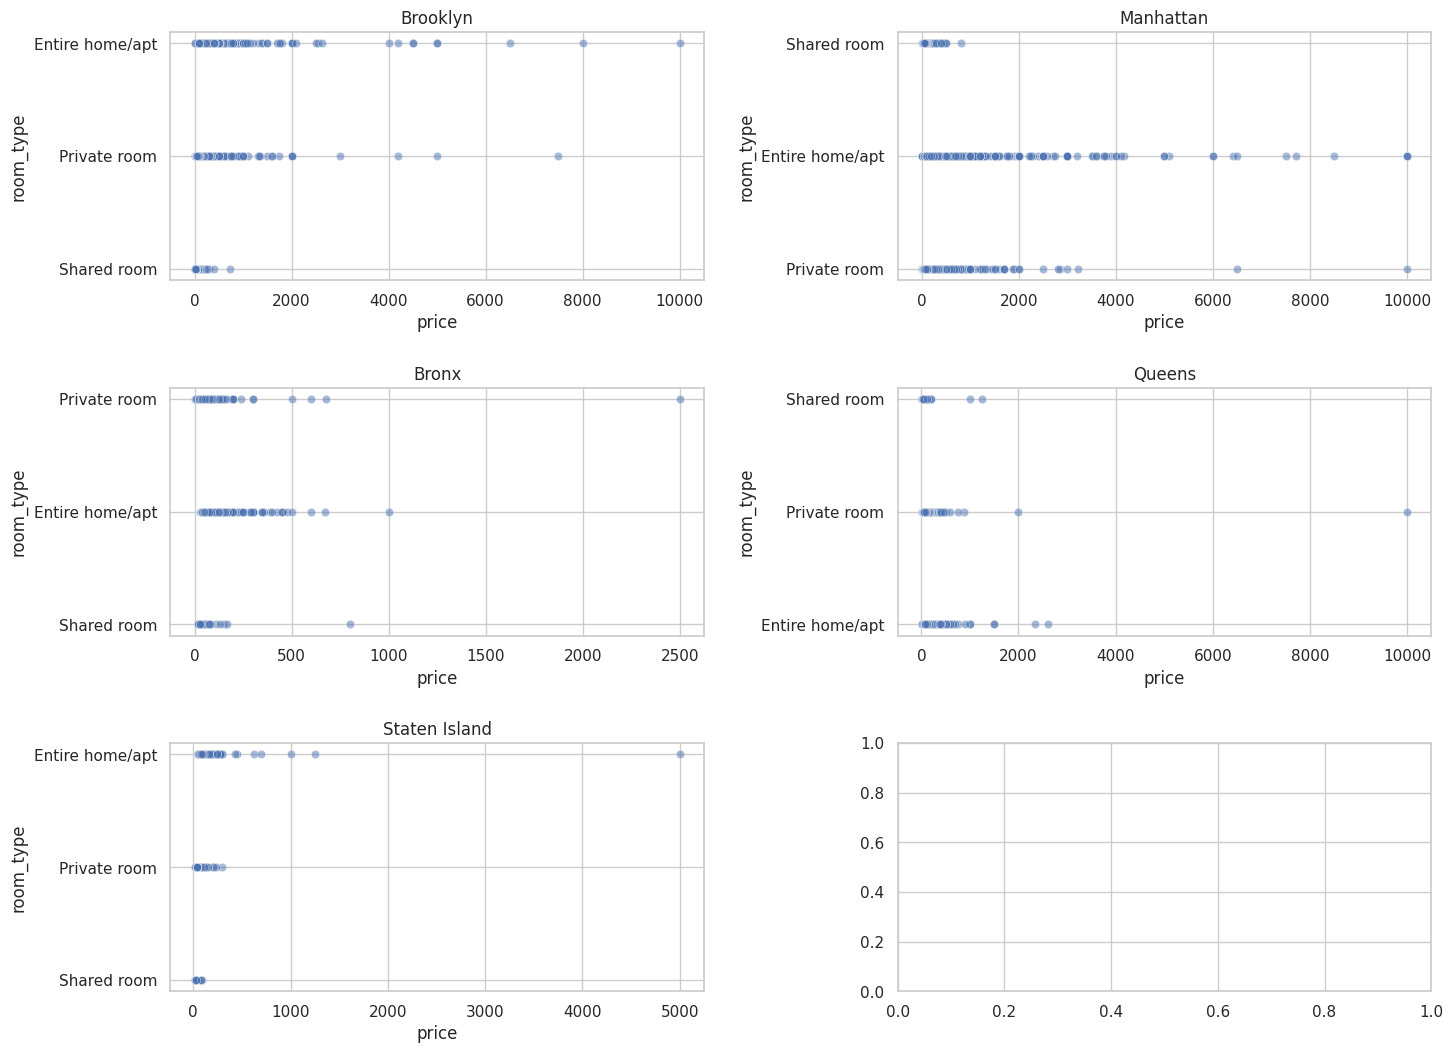

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,11))
columns = ['Brooklyn','Manhattan','Bronx','Queens','Staten Island']
color = ['red']

for column,axes in zip(columns, ax.flatten()):
    axes.title.set_text('{}'.format(column))
    sns.scatterplot(y=train[train.neighbourhood_group == column]['room_type'],x=train[train.neighbourhood_group == column]['price'],ax=axes, alpha=0.5)


plt.tight_layout(pad=2.0)
plt.show()

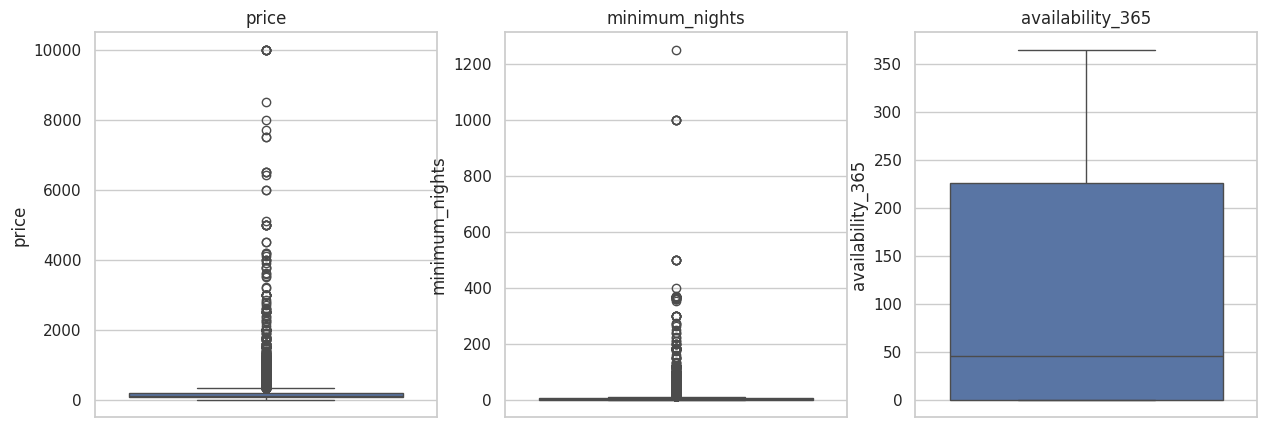

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,5))
columns=['price','minimum_nights','availability_365']
for column,axes in zip(columns, ax.flatten()):
    sns.boxplot(train[column],ax=axes)
    axes.title.set_text(column)

plt.show()


In [13]:
%pip install joypy

It seems we also have a lot of outliers.

Let's add a new column 'Borough/room_type'which is cross product of Borough and room_type

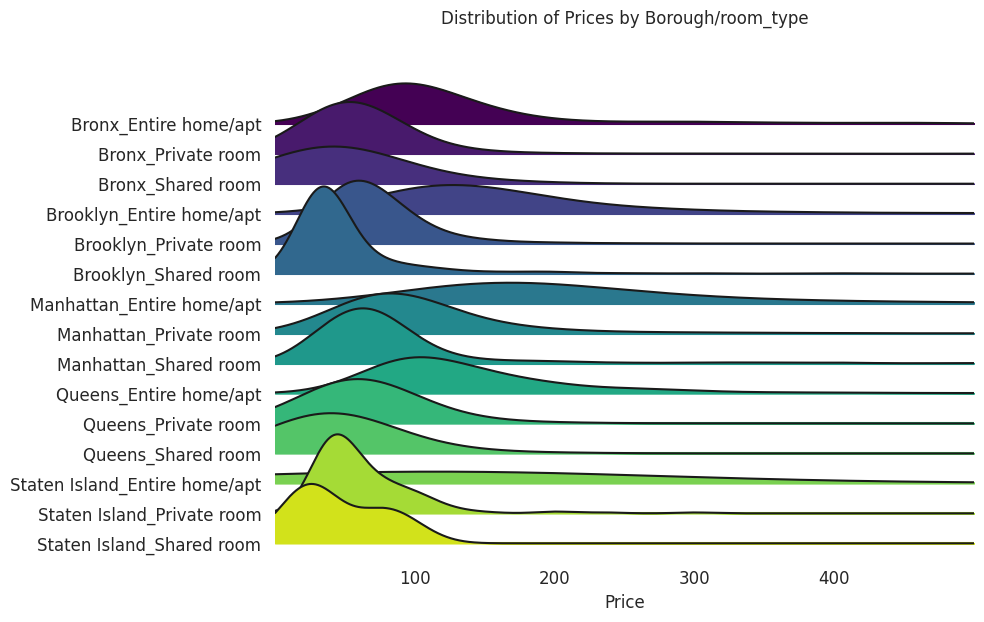

In [14]:

import matplotlib.pyplot as plt
import seaborn as sns
import joypy

train['Borough/room_type'] = train['neighbourhood_group'] + '_' + train['room_type']

fig, ax = joypy.joyplot(
    data=train,
    by='Borough/room_type',
    column='price',
    figsize=(10, 6),
    colormap=plt.cm.viridis,
    x_range=(0, 500)
)



# Add titles and labels
plt.title('Distribution of Prices by Borough/room_type')
plt.xlabel('Price')
plt.ylabel('Borough/room_type')

# Show the plot
plt.show()


We can see that different Borough/room_type's have different distributions. Now, let's see how bad outliers and how skewd distributions are.

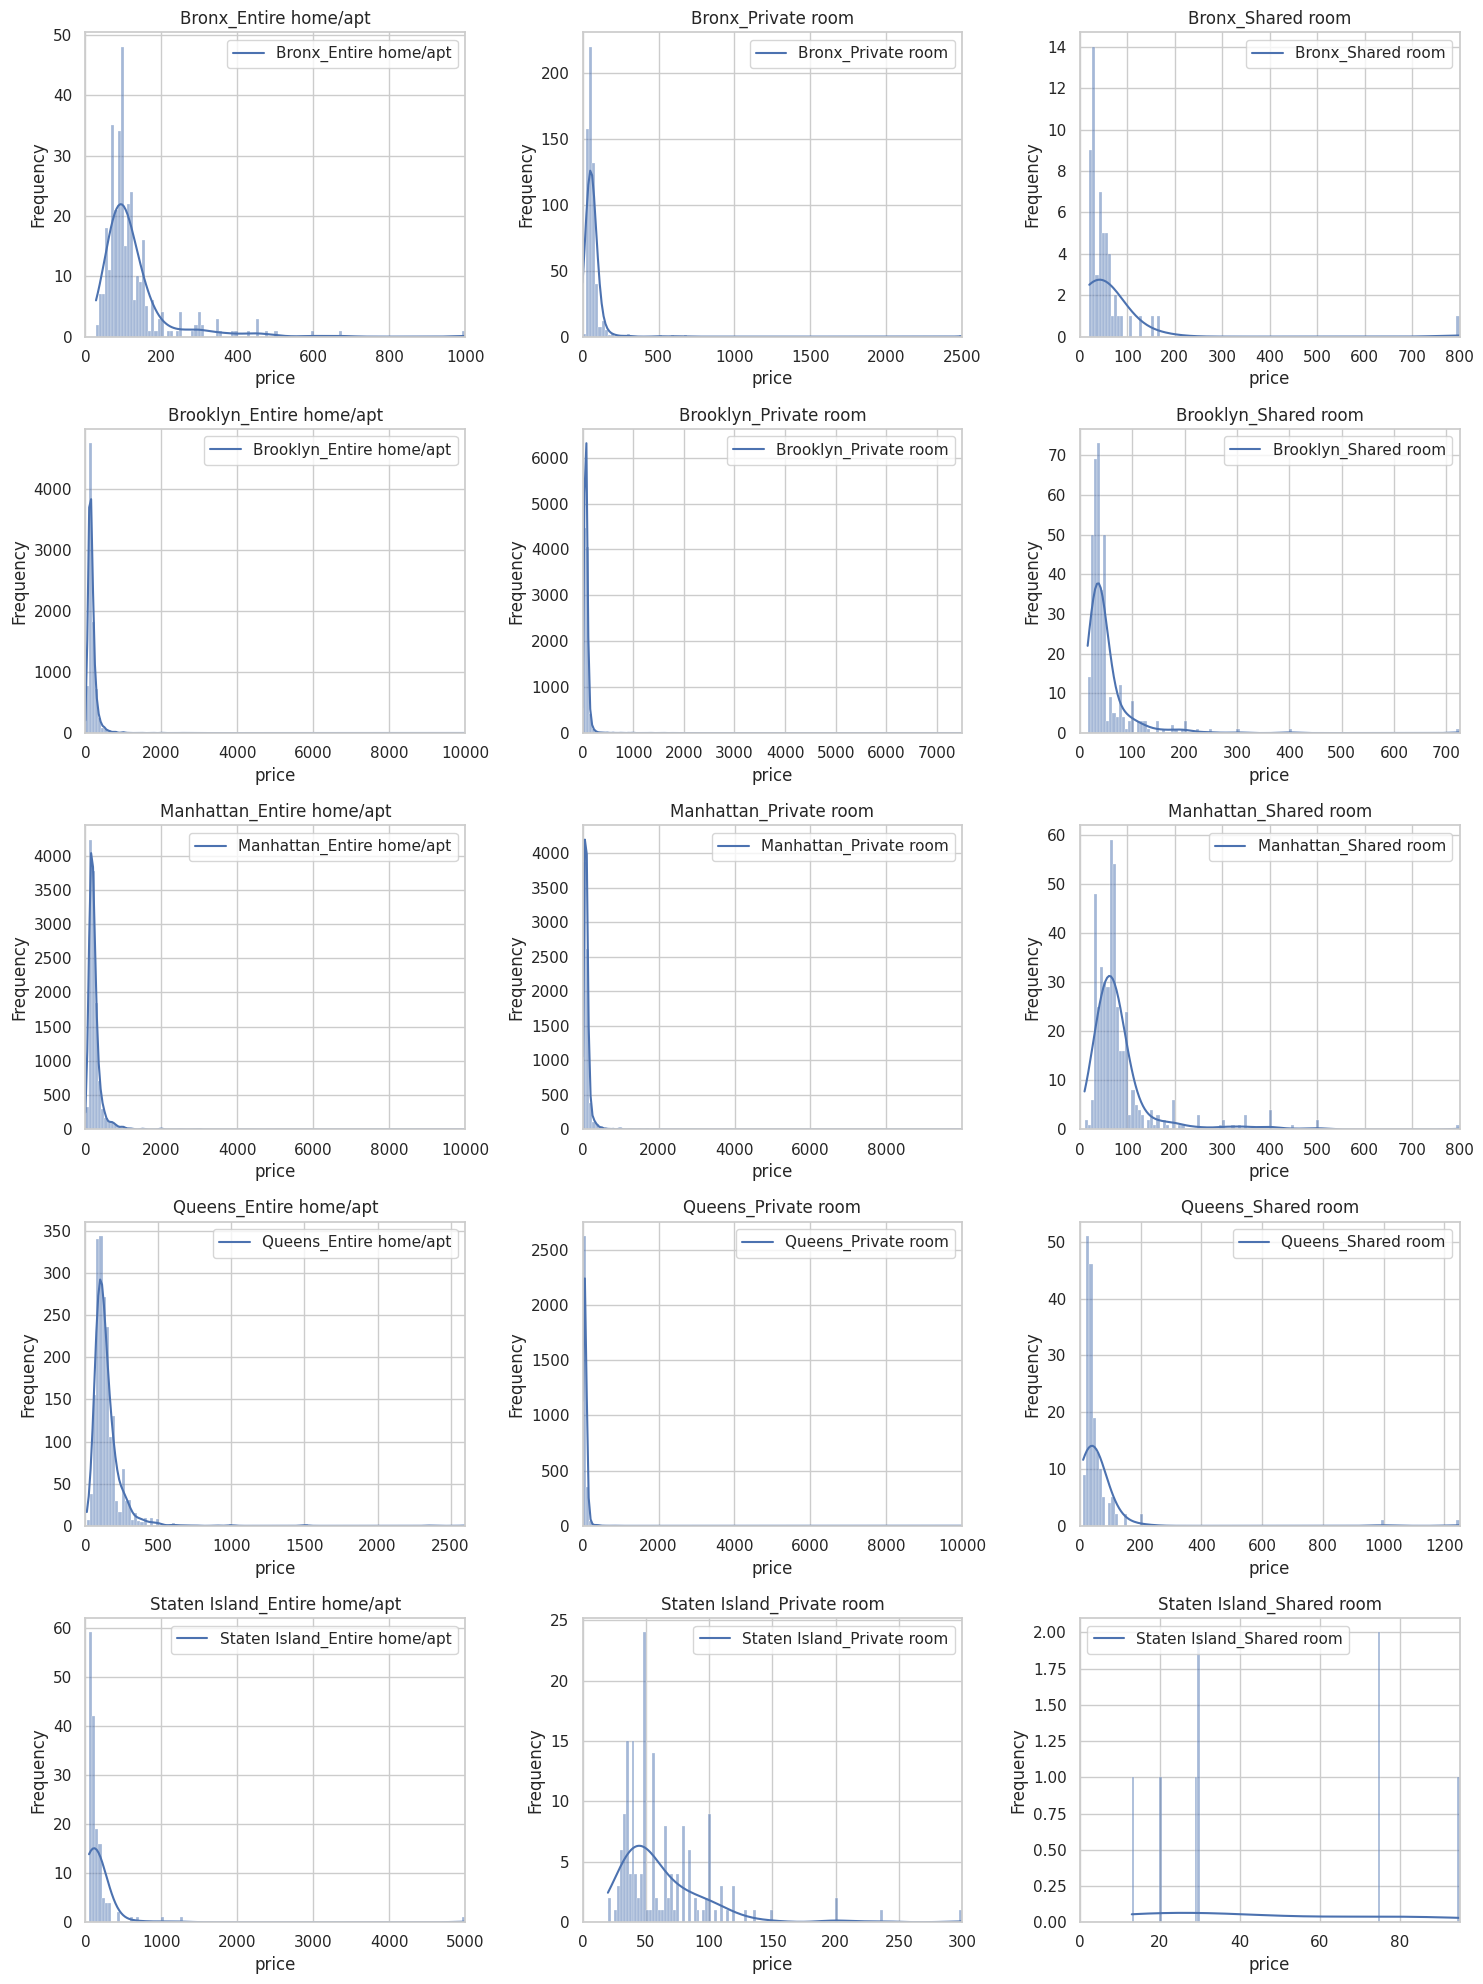

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axs = plt.subplots(5, 3, figsize=(15, 20))  # 5 rows, 3 columns

# Flatten the axs array for easier iteration
axs = axs.flatten()

A = train.copy()

grouped = A.groupby('Borough/room_type')

# Plot histograms and KDE for each group
for ax, (name, group) in zip(axs, grouped):
    sns.histplot(group['price'], bins=120, kde=True, ax=ax)
    ax.set_title(f'{name}')
    ax.set_xlabel('price')
    ax.set_ylabel('Frequency')
    ax.legend([name])
    ax.set_xlim(0, group['price'].max())

# Hide any unused subplots
for i in range(len(grouped), len(axs)):
    fig.delaxes(axs[i])

plt.tight_layout()
plt.show()

It looks very skewed to me. We will do logarithmic transformation on price later in feature engineering.

# Feature Engineering

price in both train and test data frame will be transformed by log10(x)

Regarding handling outliers of price column, only data points within 2 standard deviation of mean ( 95 percent interval ) will be considered and outliers will be mean+-2*sd

In [16]:
# Adjust values: Replace zero and negative values to avoid log(0) and log(negative)
train['AdjustedValue'] = train['price'].replace(0, np.nan)
train.loc[train['AdjustedValue'] < 0, 'AdjustedValue'] = np.nan

# Perform log10(1 + x) transformation
train['price'] = np.log10(1 + train['AdjustedValue'])


# Adjust values: Replace zero and negative values to avoid log(0) and log(negative)
test['AdjustedValue'] = test['price'].replace(0, np.nan)
test.loc[test['AdjustedValue'] < 0, 'AdjustedValue'] = np.nan

# Perform log10(1 + x) transformation
test['price'] = np.log10(1 + test['AdjustedValue'])

train = train.drop(columns=['AdjustedValue'])
test = test.drop(columns=['AdjustedValue'])

In [17]:
from sklearn.preprocessing import StandardScaler


# Copy the DataFrame
new_train = train.copy()
new_train = new_train[['Borough/room_type', 'price']]

# Calculate mean and std deviation for each group
train_grouped_mean = new_train.groupby('Borough/room_type').mean()
train_grouped_std = new_train.groupby('Borough/room_type').std()

# Group the DataFrame by 'Borough/room_type'
grouped = train.groupby('Borough/room_type')

# Function to set outliers
def set_outlier(x, lower, upper):
    if x <= lower:
        return lower
    elif x >= upper:
        return upper
    else:
        return x

# List of unique Borough/room_type combinations
Borough_room_type_list = list(train_grouped_mean.index)

# Function to apply StandardScaler and handle outliers
def scale_and_outliers(group):
    lower = train_grouped_mean.loc[group.name, 'price'] - 2 * train_grouped_std.loc[group.name, 'price']
    upper = train_grouped_mean.loc[group.name, 'price'] + 2 * train_grouped_std.loc[group.name, 'price']

    group['price'] = group['price'].apply(set_outlier, args=(lower, upper))

    scaler = StandardScaler()
    group['price_z_score'] = scaler.fit_transform(group[['price']])

    return group

# Apply the function to each group
train = grouped.apply(scale_and_outliers).reset_index(drop=True)

# Display the modified DataFrame
# print("Modified DataFrame:")
# print(train)


In [18]:
test['Borough/room_type'] = test['neighbourhood_group'] + '_' + test['room_type']

# Copy the DataFrame
new_test = test.copy()
new_test = new_test[['Borough/room_type', 'price']]

# Calculate mean and std deviation for each group
test_grouped_mean = new_test.groupby('Borough/room_type')['price'].mean()
test_grouped_std = new_test.groupby('Borough/room_type')['price'].std()

# Group the DataFrame by 'Borough/room_type'
grouped = test.groupby('Borough/room_type')

def scale_and_outliers(group):
    lower = train_grouped_mean.loc[group.name, 'price'] - 2 * train_grouped_std.loc[group.name, 'price']
    upper = train_grouped_mean.loc[group.name, 'price'] + 2 * train_grouped_std.loc[group.name, 'price']

    group['price'] = group['price'].apply(set_outlier, args=(lower, upper))

    scaler = StandardScaler()
    group['price_z_score'] = scaler.fit_transform(group[['price']])

    return group

# Apply the function to each group
test = grouped.apply(scale_and_outliers).reset_index(drop=True)



Mapping different Borough/room_type classes to numbers below:

In [19]:
## both train and test
class_mapping={}
i=0

for x in train['Borough/room_type'].unique():
    class_mapping[x]=i
    i=i+1

train['Borough/room_type'] = train['Borough/room_type'].map(class_mapping)
test['Borough/room_type'] = test['Borough/room_type'].map(class_mapping)


### Feature selection:

'neighbourhood' column has very high cardinality which contributes to model complexity and class imbalance. Let's drop it.
We also don't need 'price_z_score' anymore and we have addressed 'neighbourhood_group' and 'room_type' by creating a cross feature.

In [20]:
train = train.drop(columns=['neighbourhood','price_z_score','neighbourhood_group','room_type'])
test = test.drop(columns=['neighbourhood','price_z_score','neighbourhood_group','room_type'])

### Class imbalance handling

Let's first handle class imbalance in Borough/room_type column. I'll do sample weighting techniques.

In [21]:
## both train and test set
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
classes = np.unique(train['Borough/room_type'])
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=train['Borough/room_type'])
class_weight_dict = dict(zip(classes, class_weights))

# Assign weights to samples
train['Weight'] = train['Borough/room_type'].map(class_weight_dict)

class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=test['Borough/room_type'])
class_weight_dict = dict(zip(classes, class_weights))

test['Weight'] = test['Borough/room_type'].map(class_weight_dict)

Checking for NaN values in train and test dataframes.

In [22]:
print(test[test['price'].isna()])

print(train[train['price'].isna()])

      price  minimum_nights  number_of_reviews  reviews_per_month  \
2102    NaN              30                  2               0.11   
2125    NaN              30                  5               0.26   

      availability_365  Borough/room_type    Weight  
2102               333                  5  7.086957  
2125               139                  5  7.086957  
       price  minimum_nights  number_of_reviews  reviews_per_month  \
369      NaN               2                 55           2.560000   
9566     NaN               5                  3           0.150000   
10361    NaN               1                 95           4.350000   
11398    NaN               1                 93           4.280000   
14060    NaN               4                  1           0.050000   
14080    NaN               2                 16           0.710000   
15238    NaN               2                 12           0.530000   
15893    NaN               1                 95           4.370000   


In [23]:
train = train.dropna(subset=['price'])
test = test.dropna(subset=['price'])

### potentially pca

# Machine learning

Dont forget to use the WEIGHTS in model training



use PCA afterwards and compare

In [24]:
from sklearn.linear_model import Ridge, RidgeCV, ElasticNetCV, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

X_train = train.drop(columns=['price'])
y=train['price']

def rmse_cv(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))
    return rmse

In [25]:
m_ridge = make_pipeline(StandardScaler(),Ridge())

In [26]:
print(train[train['price'].isna()])

Empty DataFrame
Columns: [price, minimum_nights, number_of_reviews, reviews_per_month, availability_365, Borough/room_type, Weight]
Index: []


In [27]:
alphas_ridge = [0.05,0.1,0.3,1,3,5,10]

cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas_ridge]

Text(0, 0.5, 'rmse')

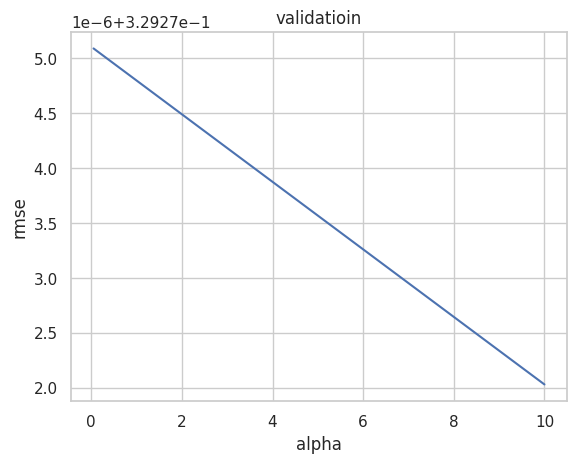

In [28]:
cv_ridge = pd.Series(cv_ridge, index=alphas_ridge)
cv_ridge.plot(title = 'validatioin')
plt.xlabel('alpha')
plt.ylabel('rmse')

In [29]:
from sklearn.model_selection import KFold

kfolds = KFold(n_splits=10,shuffle=True)

def cv_rmse(model, X_train):
    rmse = np.sqrt(-cross_val_score(model, X_train, y,
                                    scoring="neg_mean_squared_error",
                                    cv=kfolds))
    return (rmse)

### Lasso

In [30]:
lasso = make_pipeline(StandardScaler(), LassoCV(max_iter=10000000,alphas=[5e-05, 0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007, 0.0008]))

In [31]:
score = cv_rmse(lasso, X_train)
print('Lasso Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

Lasso Score 0.2758 (0.0017)


### Ridge

In [32]:
ridge = make_pipeline(StandardScaler(), RidgeCV(alphas=[14.5, 14.6, 14.7, 14.8, 14.9, 15, 15.1, 15.2, 15.3, 15.4, 15.5]))

score = cv_rmse(ridge, X_train)
print('Ridge Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

Ridge Score 0.2759 (0.0021)


### ElasticNet

In [33]:
elastic = make_pipeline(StandardScaler(), ElasticNetCV(alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006, 0.0007],
                                                     l1_ratio=[0.8, 0.85, 0.9, 0.95, 0.99, 1]))

score = cv_rmse(elastic, X_train)
print('Elastic Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

Elastic Score 0.2758 (0.0020)


### SVR

In [34]:
from sklearn.svm import SVR

svr = make_pipeline(StandardScaler(), SVR(C=20, epsilon=0.008, gamma=0.0003))

score = cv_rmse(svr, X_train)
print('SVR Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

SVR Score 0.2690 (0.0024)


### GradientBoostingRegressor

In [35]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, loss='huber', random_state=42)

score = cv_rmse(gbr, X_train)
print('GBR Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

GBR Score 0.1824 (0.0023)


### LightGBM

In [36]:
import warnings
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

lgb = LGBMRegressor(objective='regression', learning_rate=0.08, n_estimators=4000, num_leaves=32,max_depth=7, reg_alpha=0.0001)

score = cv_rmse(lgb, X_train)
print('LGBM Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

### Catboost

In [39]:
!pip install catboost
from catboost import CatBoostRegressor


catboost = CatBoostRegressor(learning_rate=0.05, n_estimators=10000, max_depth=5, verbose=False, random_seed=42,
                            max_leaves=32, min_data_in_leaf=1)

score = cv_rmse(catboost, X_train)
print('Catboost Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 2.8 MB/s eta 0:00:00
Catboost Score 0.1823 (0.0010)


### XGboost

In [40]:
from xgboost import XGBRegressor
xgb = XGBRegressor(learning_rate=0.08, n_estimators=3000, max_depth=7, reg_alpha=0.0001, objective='reg:squarederror', max_leaves=10)
score = cv_rmse(xgb, X_train)
print('XGB Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

XGB Score 0.1819 (0.0017)


### RandomForest

In [41]:
from sklearn.ensemble import RandomForestRegressor

rnd = RandomForestRegressor(n_estimators=4000, criterion='friedman_mse', max_depth=7, random_state=42, n_jobs=4, min_samples_leaf=10)

score = cv_rmse(rnd, X_train)
print('Random_forest Score {:.4f} ({:.4f})'.format(score.mean(),score.std()))

Random_forest Score 0.1837 (0.0006)


### StackPred

In [42]:
from sklearn.ensemble import StackingRegressor

est = [('lasso', lasso), ('ridge', ridge), ('elastic', elastic), ('rnadomforest',rnd), ('gradient', gbr),('xgboost', xgb), ('lightgmb',lgb), ('cat', catboost)]
stack_gen = StackingRegressor(estimators=est,
                                final_estimator=gbr,
                                n_jobs=4)

In [43]:
import warnings
from lightgbm import LGBMRegressor
warnings.filterwarnings('ignore', category=UserWarning, module='lightgbm')

stack_gen.fit(X_train, y)
lasso.fit(X_train,y)
ridge.fit(X_train,y)
elastic.fit(X_train,y)
svr.fit(X_train,y)
gbr.fit(X_train,y)
xgb.fit(X_train,y)
lgb.fit(X_train,y)
rnd.fit(X_train,y)
catboost.fit(X_train, y)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001055 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 846
[LightGBM] [Info] Number of data points in the train set: 43996, number of used features: 6
[LightGBM] [Info] Start training from score 2.049848
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

## Test Prediction

In [46]:
def blend_models_prediction(X):
      return ((0.4 * gbr.predict(X)) + \
            (0.15 * xgb.predict(X)) + \
            (0.3 * catboost.predict(X)) + \
            (0.15 * stack_gen.predict(X)))

In [47]:
from sklearn.metrics import mean_squared_error
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [48]:
score = rmsle(y,blend_models_prediction(X_train))
print('RMSLE Score on train data {}'.format(score))

RMSLE Score on train data 0.16575602510024653


In [49]:
prediction_blend = blend_models_prediction(test.drop('price', axis=1))
prediction_stack = stack_gen.predict(test.drop('price', axis=1))

In [50]:
submission = pd.DataFrame({'id': test.index,
                           'estimated_price_blend':np.exp(prediction_blend),
                           'estimated_price_stack':np.exp(prediction_stack),
                          'actual_price':np.exp(test['price'])})

### include version of dependencies used.

In [51]:
submission.to_csv('blend.csv', index=False)

In [53]:
!pip freeze > requirements.txt